# Dataset download

In [1]:
# !pip install kaggle

In [2]:
#!kaggle datasets download -d mrdaniilak/russia-real-estate-20182021
#!unzip russia-real-estate-20182021.zip

# The code

## Part 1. Data preparing

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Step 1. First look

In [4]:
df = pd.read_csv("all_v2.csv")

In [5]:
def describe_df(df):
    """
    Вычисляет описательную статистику для каждого столбца DataFrame.

    Args:
        df: pandas DataFrame.

    Returns:
        pandas DataFrame с описательной статистикой.
    """

    results = []
    for col in df.columns:
        missing_percentage = (df[col].isnull().sum() / len(df)) * 100
        try:  # Обработка ошибок для нечисловых столбцов
            min_val = df[col].min()
            p1 = np.nanpercentile(df[col], 1)
            p5 = np.nanpercentile(df[col], 5)
            median = df[col].median()
            mean = df[col].mean()
            p95 = np.nanpercentile(df[col], 95)
            p99 = np.nanpercentile(df[col], 99)
            max_val = df[col].max()
        except TypeError:
            min_val = np.nan
            p1 = np.nan
            p5 = np.nan
            median = np.nan
            mean = np.nan
            p95 = np.nan
            p99 = np.nan
            max_val = np.nan

        results.append([missing_percentage, min_val, p1, p5, median, mean, p95, p99, max_val])

    result_df = pd.DataFrame(results, columns=['% пропусков', 'Минимум', '1% перцентиль', '5% перцентиль', 'Медиана', 'Среднее', '95% перцентиль', '99% перцентиль', 'Максимум'], index=df.columns)
    return result_df

In [6]:
description = describe_df(df)
print(description)

               % пропусков       Минимум  1% перцентиль  5% перцентиль  \
price                  0.0 -2.144967e+09  750000.000000   1.150000e+06   
date                   0.0           NaN            NaN            NaN   
time                   0.0           NaN            NaN            NaN   
geo_lat                0.0  4.145906e+01      43.430700   4.489504e+01   
geo_lon                0.0  1.989020e+01      29.851724   3.031855e+01   
region                 0.0  3.000000e+00       3.000000   3.000000e+00   
building_type          0.0  0.000000e+00       0.000000   0.000000e+00   
level                  0.0  1.000000e+00       1.000000   1.000000e+00   
levels                 0.0  1.000000e+00       2.000000   3.000000e+00   
rooms                  0.0 -2.000000e+00      -1.000000  -1.000000e+00   
area                   0.0  7.000000e-02      19.800000   2.900000e+01   
kitchen_area           0.0  1.000000e-02       2.000000   5.000000e+00   
object_type            0.0  1.000000e+

### Step 2. Corrections

In [7]:
df.dropna()
df = df.drop(['time', 'region'], axis=1)

In [8]:
df = df[(df['rooms'] >= -1)]
df = df[(df['rooms'] != 0)]

In [9]:
price_p5 = np.percentile(df['price'], 5) # not too small as minus two billions
price_p95 = np.percentile(df['price'], 95) #not too large as plus two billions
df = df[(df['price'] >= price_p5) & (df['price'] <= price_p95)]
df = df[(df['area'] >= 10)]
df = df[(df['kitchen_area'] < df['area'])]

In [10]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df = df.drop(["date"], axis=1)

### Step 3. Statistical analysis

In [11]:
description = describe_df(df)
print(description)

               % пропусков       Минимум  1% перцентиль  5% перцентиль  \
price                  0.0  1.150000e+06   1.190000e+06   1.350000e+06   
geo_lat                0.0  4.145906e+01   4.342965e+01   4.489190e+01   
geo_lon                0.0  1.989020e+01   2.977690e+01   3.032645e+01   
building_type          0.0  0.000000e+00   0.000000e+00   0.000000e+00   
level                  0.0  1.000000e+00   1.000000e+00   1.000000e+00   
levels                 0.0  1.000000e+00   2.000000e+00   4.000000e+00   
rooms                  0.0 -1.000000e+00  -1.000000e+00  -1.000000e+00   
area                   0.0  1.000000e+01   2.080000e+01   2.990000e+01   
kitchen_area           0.0  1.000000e-02   2.700000e+00   5.000000e+00   
object_type            0.0  1.000000e+00   1.000000e+00   1.000000e+00   
year                   0.0  2.018000e+03   2.018000e+03   2.018000e+03   
month                  0.0  1.000000e+00   1.000000e+00   1.000000e+00   

                    Медиана       Сре

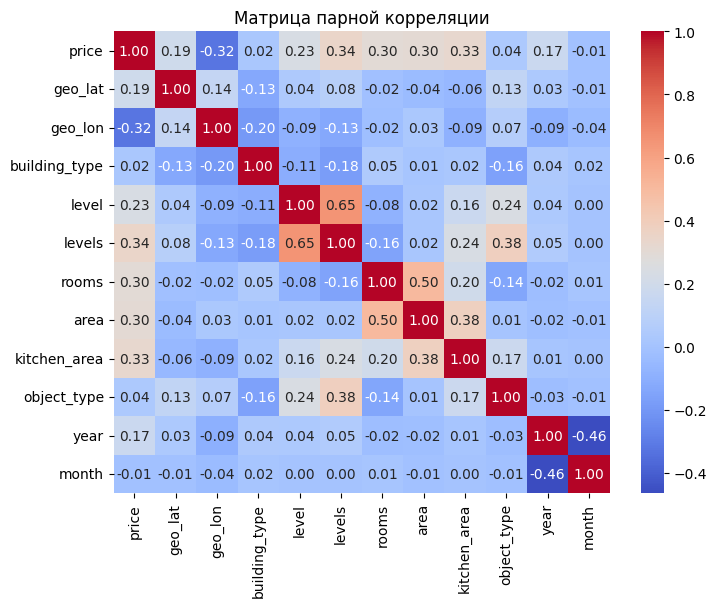

In [12]:
correlation_matrix = df.corr()

# Визуализация матрицы (тепловая карта)
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # annot=True - выводит значения корреляции на графике, cmap - цветовая схема
plt.title('Матрица парной корреляции')
plt.show()


Theoretically we should remove features "month", "building_type", "object_type". But in fact experiments show that this information helps reduce model inaccuracy by 3%.

In [13]:

def feature_interaction_correlation(df, target_column):
    """
    Строит матрицу корреляций взаимодействий признаков с целевым признаком.

    Args:
        df: pandas DataFrame с данными.
        target_column: Название столбца с целевым признаком.

    Returns:
        pandas DataFrame: Матрица корреляций.
        matplotlib.axes._subplots.AxesSubplot: Тепловая карта матрицы.
    """


    numerical_features = df.select_dtypes(include=np.number).columns  # Выбираем только числовые признаки
    n_features = len(numerical_features)
    interaction_correlations = pd.DataFrame(np.zeros((n_features, n_features)), index=numerical_features, columns=numerical_features)


    for i in range(n_features):
        for j in range(n_features):
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]

            if feature1 == target_column or feature2 == target_column:  # Пропускаем взаимодействие с самим целевым признаком
                continue


            interaction_feature = df[feature1] * df[feature2] #Создаём новый признак-произведение
            correlation = np.corrcoef(interaction_feature, df[target_column])[0, 1]  # Расчитываем корреляцию
            interaction_correlations.loc[feature1, feature2] = correlation


    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(interaction_correlations, annot=True, cmap='coolwarm', fmt=".2f", center = 0)
    plt.title(f'Корреляция взаимодействия признаков с {target_column}')

    return interaction_correlations, ax

(               price   geo_lat   geo_lon  building_type     level    levels  \
 price            0.0  0.000000  0.000000       0.000000  0.000000  0.000000   
 geo_lat          0.0  0.199224 -0.285097       0.058500  0.255456  0.370348   
 geo_lon          0.0 -0.285097 -0.290160      -0.128663  0.049309  0.073914   
 building_type    0.0  0.058500 -0.128663       0.002854  0.196965  0.261662   
 level            0.0  0.255456  0.049309       0.196965  0.223490  0.277484   
 levels           0.0  0.370348  0.073914       0.261662  0.277484  0.335762   
 rooms            0.0  0.321279  0.083658       0.217273  0.374432  0.481888   
 area             0.0  0.341818  0.050060       0.221870  0.354108  0.465499   
 kitchen_area     0.0  0.360881  0.055981       0.222231  0.337525  0.430371   
 object_type      0.0  0.054730 -0.111996       0.072615  0.131484  0.152814   
 year             0.0  0.192848 -0.324181       0.022580  0.234503  0.344344   
 month            0.0  0.018963 -0.19546

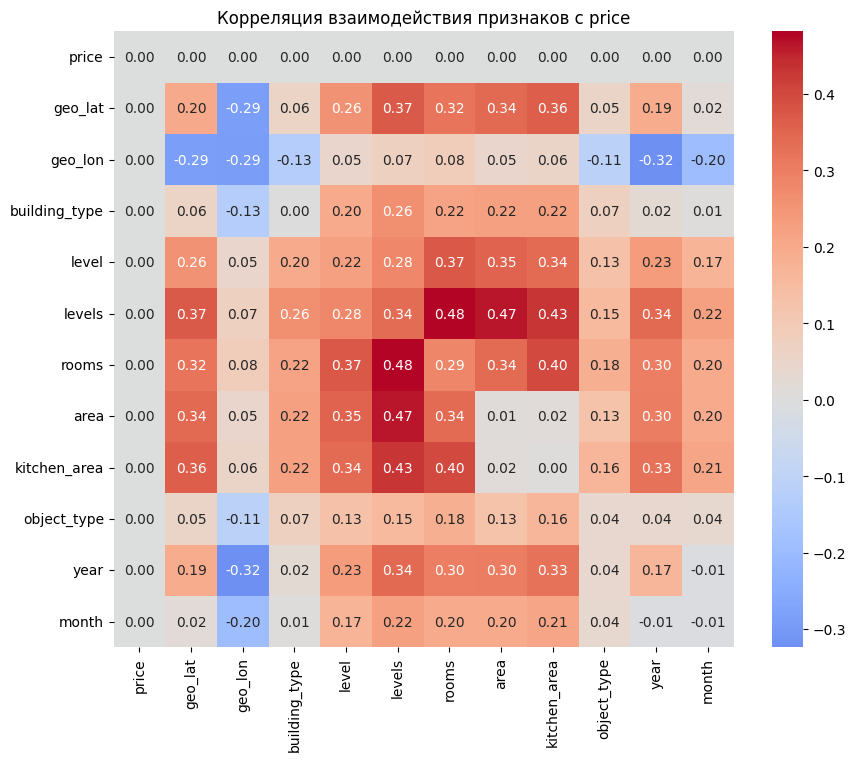

In [14]:
feature_interaction_correlation(df, "price")

In [15]:
df["levels_rooms"] = df["levels"] * df["rooms"]
df["levels_area"] = df["levels"] * df["area"]

In [16]:
inflation_dct = {
    (2018, 1): 1,
    (2018, 2): 1.0031,
    (2018, 3): 1.00520651,
    (2018, 4): 1.008121608879,
    (2018, 5): 1.01195247099274,
    (2018, 6): 1.0157978903825124,
    (2018, 7): 1.0207753000453867,
    (2018, 8): 1.0235313933555092,
    (2018, 9): 1.0236337464948448,
    (2018, 10): 1.0252715604892366,
    (2018, 11): 1.028860010950949,
    (2018, 12): 1.0340043110057036,
    (2018, 13): 1.0426899472181514,
    (2019, 2): 1.0532211156850548,
    (2019, 3): 1.057855288594069,
    (2019, 4): 1.0612404255175703,
    (2019, 5): 1.0643180227515712,
    (2019, 6): 1.0679367040289265,
    (2019, 7): 1.068363878710538,
    (2019, 8): 1.0705006064679592,
    (2019, 9): 1.0679314050124362,
    (2019, 10): 1.0662227147644163,
    (2019, 11): 1.06760880429361,
    (2019, 12): 1.070598108945632,
    (2019, 13): 1.0744522621378363,
    (2020, 2): 1.0787500711863875,
    (2020, 3): 1.0823099464213026,
    (2020, 4): 1.0882626511266198,
    (2020, 5): 1.0972952311309707,
    (2020, 6): 1.1002579282550242,
    (2020, 7): 1.1026784956971853,
    (2020, 8): 1.1065378704321256,
    (2020, 9): 1.1060952552839527,
    (2020, 10): 1.105320988605254,
    (2020, 11): 1.1100738688562566,
    (2020, 12): 1.117955393325136,
    (2020, 13): 1.1272344230897346,
    (2021, 2): 1.1347868937244359,
    (2021, 3): 1.1436382314954865,
    (2021, 4): 1.1511862438233567,
    (2021, 5): 1.157863124037532,
    (2021, 6): 1.1664313111554099,
    (2021, 7): 1.1744796872023822,
    (2021, 8): 1.1781205742327097,
    (2021, 9): 1.1801233792089052,
    (2021, 10): 1.1872041194841587,
    (2021, 11): 1.200382085210433,
    (2021, 12): 1.2119057532284532,
    (2021, 13): 1.2218433804049265,
}


In [17]:
df["price"] = df["price"] / df.apply(
    lambda row: inflation_dct.get((row["year"], row["month"]), 1), axis=1
)

## Part 2. Models learning

In [18]:
from catboost import CatBoostRegressor, Pool
from joblib import dump, load
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

### Step 0. Useful functions

In [103]:
def results_metrics(predictions, target_test):
    me = (predictions - target_test).mean()
    rmse = root_mean_squared_error(target_test, predictions)
    mae = mean_absolute_error(target_test, predictions)
    r2 = r2_score(target_test, predictions)
    rmse_relative = rmse / target_test.mean()
    mae_relative = mae / target_test.mean()
    mape = np.mean(np.abs((predictions - target_test) / target_test))
    # not_abs_mape = np.mean(np.abs((target_test - predictions) / predictions))
    smape = np.mean(np.abs(predictions - target_test)) / np.mean(predictions + target_test)
    results_test = {
        "me": me,
        "rmse": rmse,
        "rmse_relative": rmse_relative,
        "mae": mae,
        "mae_relative": mae_relative,
        "mape": mape,
        # "not_abs_mape": not_abs_mape,
        "smape": smape,
        "r2": r2,
    }
    return results_test

def visualize_predictions(predictions, y_test):
    """
    Визуализирует предсказания модели, строя графики распределения ошибки, 
    процентной ошибки и диаграмму рассеяния (y_test, predictions).

    Args:
        predictions (array-like): Вектор предсказаний модели.
        y_test (array-like): Вектор истинных значений.
    """

    if len(predictions) != len(y_test):
        raise ValueError("Размеры векторов predictions и y_test должны совпадать.")

    # # Проверяем на нули в y_test для процентной ошибки
    # if np.any(y_test == 0):
    #     print("В y_test обнаружены нули. Процентная ошибка может быть некорректной.")
    #     #  Можно заменить нули на маленькое значение, 
    #     # но лучше проанализировать, почему они там появились
    #     y_test = np.where(y_test == 0, 1e-10, y_test) # Заменяем на малое значение

    
    # 1. Распределение ошибки
    error = predictions - y_test

    lower_bound = np.percentile(error, 1)
    upper_bound = np.percentile(error, 99)

    # Создаем маску для отбора значений внутри интервала
    mask = (error >= lower_bound) & (error <= upper_bound)

    # Фильтруем predictions и y_test
    error = error[mask]
    predictions = predictions[mask]
    y_test = y_test[mask]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(error, kde=True, bins=30, stat="probability")
    plt.title('Распределение ошибки')
    plt.xlabel('Ошибка')
    plt.show()

    # 2. Распределение процентной ошибки
    percentage_error = error / y_test * 100  # error/abs(y_test) - если нужна доля ошибки вне зависимости от направления.
    plt.figure(figsize=(10, 6))
    sns.histplot(percentage_error, kde=True, bins=30, stat="probability")
    plt.title('Распределение процентной ошибки')
    plt.xlabel('Процентная ошибка, %')
    plt.show()

    # 3. Диаграмма рассеяния (y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=predictions)
    plt.title('Диаграмма рассеяния (y_test, predictions)')
    plt.xlabel('Истинные значения (y_test)')
    plt.ylabel('Предсказанные значения (predictions)')
    # Добавляем линию y=x для наглядности
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
    plt.show()

### Step 1. Data splitting

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

target_train = df_train["price"]
features_train = df_train.drop(["price"], axis=1)

target_test = df_test["price"]
features_test = df_test.drop(["price"], axis=1)

### Step 2. Clustering

In [20]:

def optimize_correlation(df, target_column="price"):
    """Находит линейную комбинацию признаков, которая максимально коррелирует с заданным целевым признаком."""
    features = df.drop(columns=target_column).columns
    X = df[features].values
    P = df[target_column].values
    n = len(features)

    cov_matrix = np.cov(X, rowvar=False)
    cov_XP = np.cov(X, P, rowvar=False)[:n, n:].flatten()

    def target_function(a_rest):
        weights = np.insert(a_rest, 0, 1.0)
        L = weights @ cov_XP
        S = weights @ cov_matrix @ weights
        return -np.abs(L) / np.sqrt(S)  # Минимизируем -|L|/sqrt(S)

    initial_guess = np.zeros(n - 1)
    result = minimize(target_function, initial_guess)
    weights = np.insert(result.x, 0, 1.0)

    linear_combination = X @ weights
    correlation = np.corrcoef(linear_combination, P)[0, 1]

    return correlation, weights


n_clusters = 10

cluster_method = KMeans(n_clusters=n_clusters, random_state=42)

cluster_method.fit(features_train)

print("Кластеризовал")
df_train["cluster"] = cluster_method.predict(features_train)
df_test["cluster"] = cluster_method.predict(features_test)
df_train["optimal_combination"] = 0.1
df_test["optimal_combination"] = 0.1
cluster_correlations = []
for cluster in range(n_clusters):
    cluster_data_train = df_train[df_train["cluster"] == cluster].copy()
    cluster_data_test = df_test[df_test["cluster"] == cluster].copy()

    correlation, weights = optimize_correlation(
        cluster_data_train, target_column="price"
    )
    cluster_correlations.append(correlation)

    X_train = cluster_data_train.drop(columns=["price"]).values
    df_train.loc[df_train["cluster"] == cluster, "optimal_combination"] = (
        X_train @ weights
    )

    X_test = cluster_data_test.drop(columns=["price"]).values
    df_test.loc[df_test["cluster"] == cluster, "optimal_combination"] = X_test @ weights
print("Посчитал линкомб")

cluster_prices = (
    df_train.groupby("cluster")["price"].sum()
    / df_train.groupby("cluster")["optimal_combination"].sum()
)
print("Посчитал коэф пропорциональности")

df_train["ppc_price"] = df_train["optimal_combination"] * df_train.apply(
    lambda row: cluster_prices[row["cluster"]], axis=1
)
print("Посчитал среднюю цену train")

df_test["ppc_price"] = df_test["optimal_combination"] * df_test.apply(
    lambda row: cluster_prices[row["cluster"]], axis=1
)
print("Посчитал среднюю цену test")

X_train = df_train.drop(["price", "cluster"], axis=1)
y_train = target_train

X_test = df_test.drop(["price",  "cluster"], axis=1)
y_test = target_test


Кластеризовал
Посчитал линкомб
Посчитал коэф пропорциональности
Посчитал среднюю цену train
Посчитал среднюю цену test


### Step 3. RandomForest learning

In [73]:
N_ESTIMATORS = 10

random_forest_model = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    criterion="friedman_mse",
    # criterion="squared_error",
    random_state=1341414,
    # max_depth=40,
    max_features=1.0,
    n_jobs=15,
    # min_samples_split=4,
    # min_samples_leaf=4,
    bootstrap=True,
    verbose=0,
)
random_forest_model.fit(X_train, y_train)
print("Научил лес")
print(random_forest_model.get_params())
predictions = random_forest_model.predict(X_test)
print("Сделал предсказание")

Научил лес
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': 15, 'oob_score': False, 'random_state': 1341414, 'verbose': 0, 'warm_start': False}


{'me': -442.72322440842265, 'rmse': 624869.5552875464, 'rmse_relative': 0.18569669731346852, 'mae': 398097.20550013403, 'mae_relative': 0.11830522970042576, 'mape': 0.1278568901222954, 'smape': 0.05915650637356657, 'r2': 0.9007179319374846}


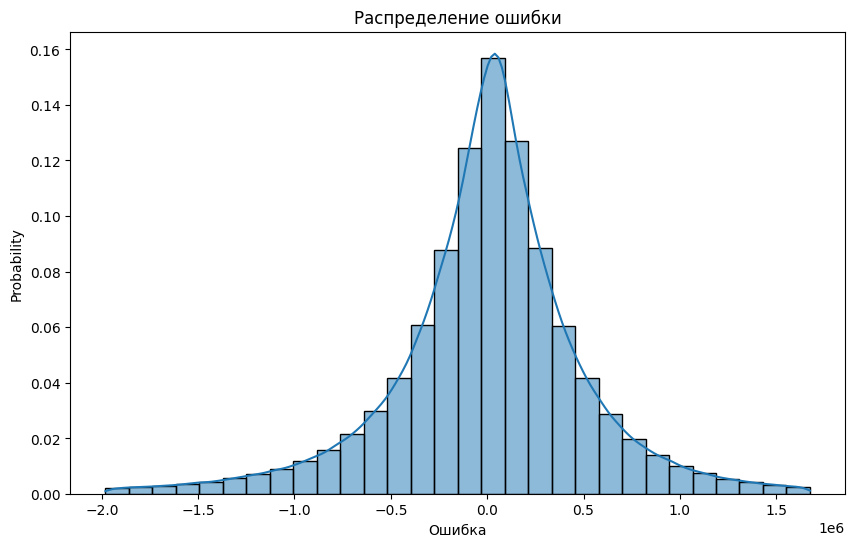

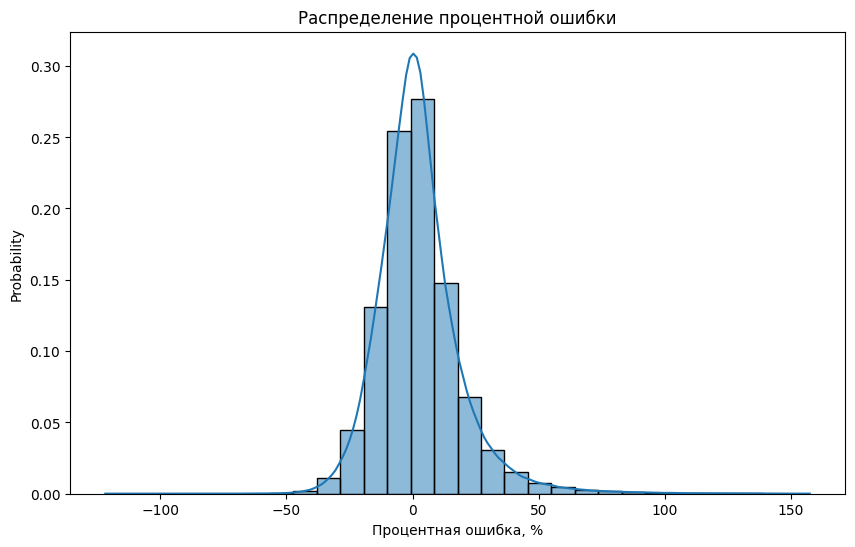

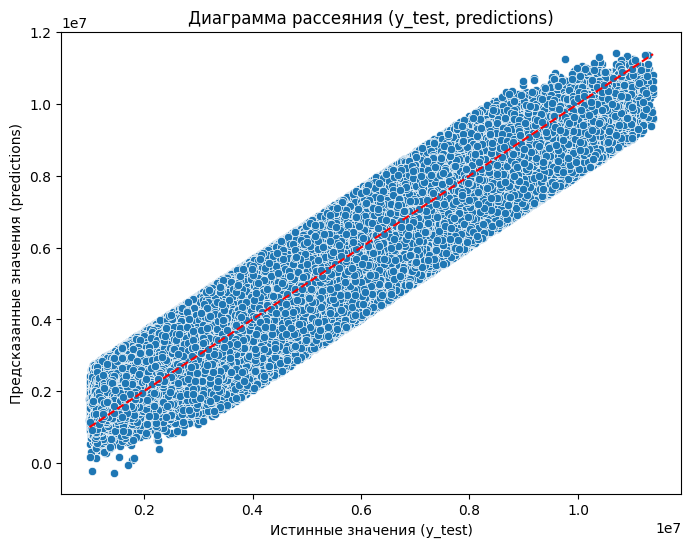

In [104]:
results_test=results_metrics(predictions, target_test)
print(results_test)
visualize_predictions(predictions, y_test)

## Step 3. CatBoost learning

In [81]:
# Определение категориальных признаков
cat_features = [
    "building_type",
    "object_type",
]  # Добавьте сюда все ваши категориальные признаки
# Создание Pool объектов для CatBoost (улучшает производительность и позволяет использовать дополнительные функции)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [100]:
catboost_model = CatBoostRegressor(
    iterations=400,  #  Увеличьте количество итераций, если необходимо
    learning_rate=0.5,  #  Подберите оптимальное значение learning_rate
    depth=10,  #  Подберите оптимальную глубину деревьев
    l2_leaf_reg=3,  #  L2 регуляризация
    loss_function="RMSE",  #  Функция потерь (RMSE - Root Mean Squared Error)
    eval_metric="MAE",  #  Метрика для оценки качества
    early_stopping_rounds=100,  #  Остановка обучения, если метрика не улучшается в течение 100 раундов
    random_seed=42,
    verbose=100,  #  Вывод информации о ходе обучения каждые 100 итераций
    task_type="GPU",  # Или "GPU" если у вас есть доступ к GPU
)

In [101]:
catboost_model.fit(    
    train_pool, eval_set=test_pool, plot=True
)  # plot=True отображает график обучения


# Предсказания на тестовом наборе
predictions = catboost_model.predict(test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 1056355.7072067	test: 1054886.5519330	best: 1054886.5519330 (0)	total: 312ms	remaining: 2m 4s
100:	learn: 445145.5505771	test: 446384.3722903	best: 446384.3722903 (100)	total: 25.4s	remaining: 1m 15s
200:	learn: 416285.3699468	test: 419636.8867749	best: 419636.8867749 (200)	total: 50.2s	remaining: 49.7s
300:	learn: 401041.3840077	test: 406957.3113593	best: 406957.3113593 (300)	total: 1m 14s	remaining: 24.6s
399:	learn: 389927.2703333	test: 398097.1810933	best: 398097.1810933 (399)	total: 1m 38s	remaining: 0us
bestTest = 398097.1811
bestIteration = 399


{'me': -442.72322440842265, 'rmse': 624869.5552875464, 'rmse_relative': 0.18569669731346852, 'mae': 398097.20550013403, 'mae_relative': 0.11830522970042576, 'mape': 0.1278568901222954, 'smape': 0.05915650637356657, 'r2': 0.9007179319374846}


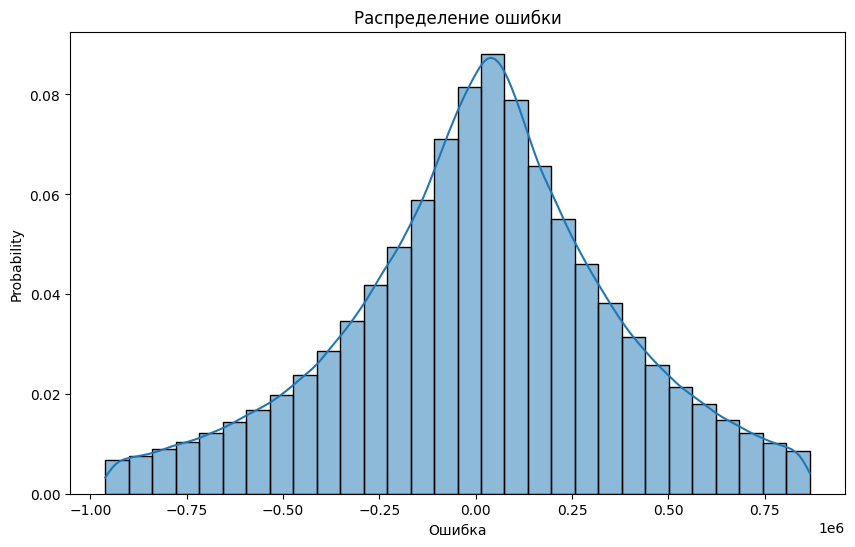

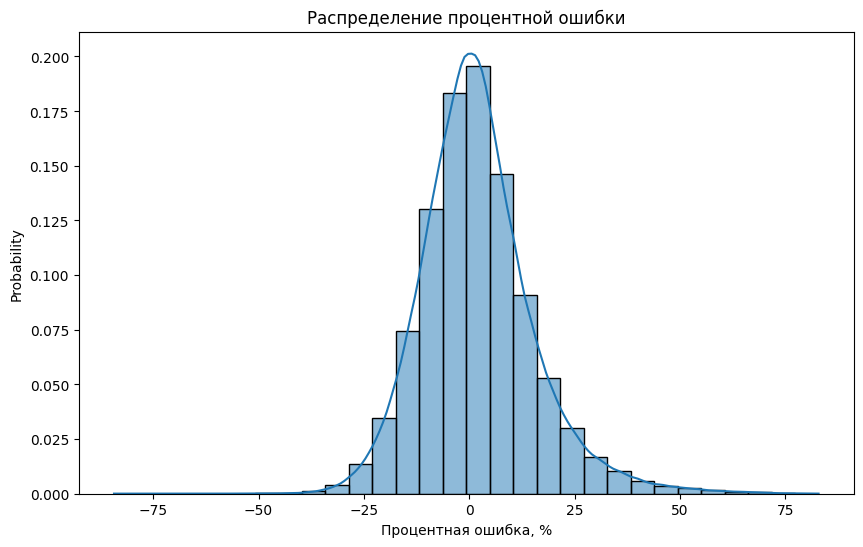

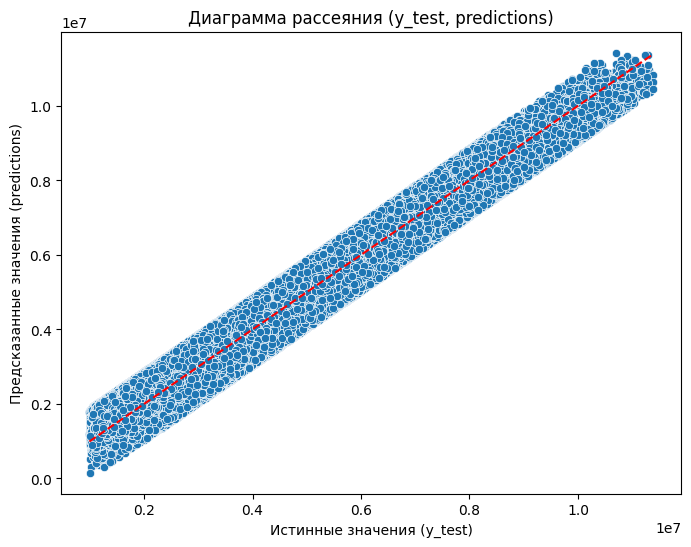

In [102]:
results_test=results_metrics(predictions, target_test)
print(results_test)
visualize_predictions(predictions, y_test)

## Step 4. NeuralNetwork learning

In [112]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [119]:
df_train_neural = pd.DataFrame()
df_test_neural = pd.DataFrame()

le_building_type = LabelEncoder()
df_train_neural["building_type"] = le_building_type.fit_transform(df_train["building_type"])
df_test_neural["building_type"] = le_building_type.transform(df_test["building_type"])

le_object_type = LabelEncoder()
df_train_neural["object_type"] = le_object_type.fit_transform(df_train["object_type"])
df_test_neural["object_type"] = le_object_type.transform(df_test["object_type"])
# 2. Масштабирование числовых признаков
numerical_features = list(df_train.columns)
numerical_features.remove("price")
numerical_features.remove("object_type")
numerical_features.remove("building_type")
scaler = StandardScaler()
df_train_neural[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test_neural[numerical_features] = scaler.transform(df_test[numerical_features])

df_train_neural["price"] = df_train["price"]
df_test_neural["price"] = df_test["price"]
X_train_neural = df_train_neural.drop(["price", "cluster"], axis=1)
y_train_neural = target_train

X_test_neural = df_test_neural.drop(["price",  "cluster"], axis=1)
y_test_neural = target_test

In [120]:
neural_network_model = tf.keras.Sequential(
    [
        # tf.keras.Input(),
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),  # Линейная активация для регрессии
    ]
)
print("Модель создана")
# Компиляция модели
neural_network_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
print("Модель скомпилирована")

# Обучение модели
history = neural_network_model.fit(
    X_train_neural,
    y_train_neural,
    epochs=50,
    batch_size=1024,
    validation_data=(X_test, y_test),
)
print("Модель обучена")

predictions = neural_network_model.predict(
    X_test_neural
).flatten()  # flatten() для корректного сравнения с y_test
print("Модель предсказала")

/home/maxwell/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Модель создана
Модель скомпилирована
Epoch 1/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 8256306020352.0000 - mae: 2173161.2500 - val_loss: 2099282277799005503094784.0000 - val_mae: 1387144806400.0000
Epoch 2/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2537909911552.0000 - mae: 1073924.2500 - val_loss: 4258366594041968158834688.0000 - val_mae: 1975918264320.0000
Epoch 3/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2073850675200.0000 - mae: 999344.5625 - val_loss: 7766638421961455551119360.0000 - val_mae: 2668634570752.0000
Epoch 4/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2016402472960.0000 - mae: 981460.5625 - val_loss: 9009118292585410096791552.0000 - val_mae: 2874172243968.0000
Epoch 5/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1935130755072.0000 - mae: 974395.7500 - val_loss: 8767267642721022592942080.0000 - val_mae: 2835354746880.0000
Epoch 6/50
3862/3862 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1966360625152.0000 - mae: 970281.8

{'me': 19450.90951074689, 'rmse': 993363.4027128953, 'rmse_relative': 0.2952044975706468, 'mae': 690333.454758256, 'mae_relative': 0.20515104554039992, 'mape': 0.2246466277401224, 'smape': 0.10227991551256346, 'r2': 0.7490955318809628}


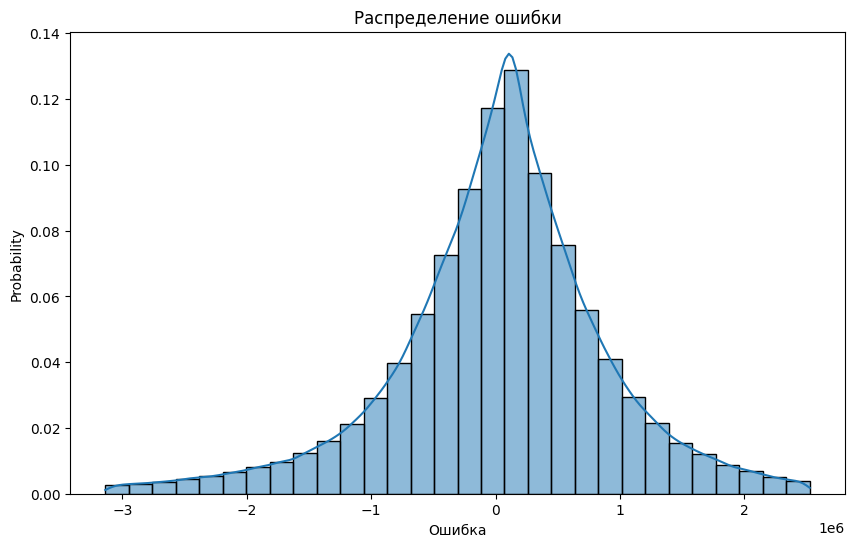

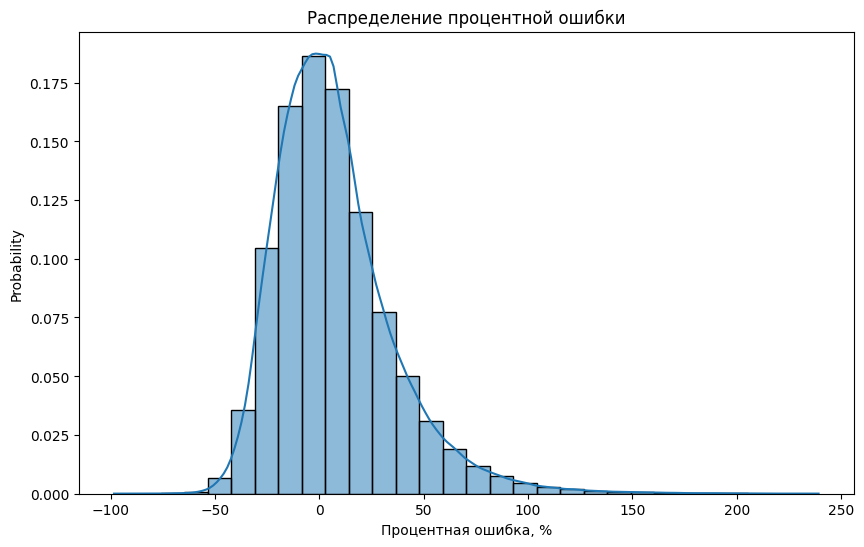

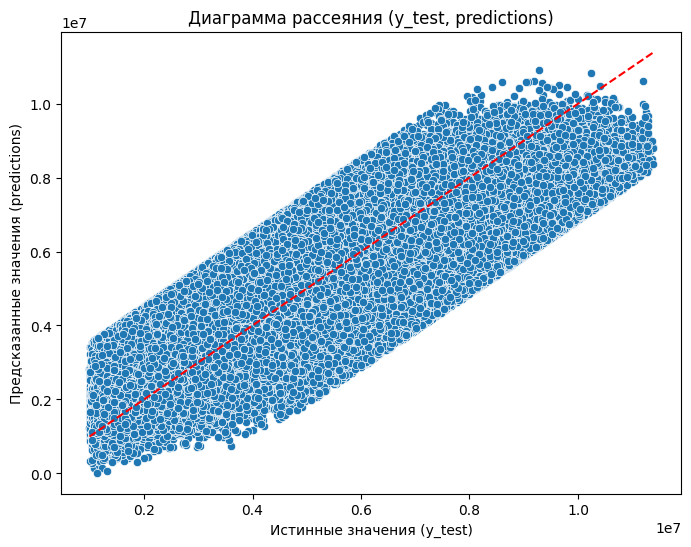

In [121]:
results_test=results_metrics(predictions, y_test)
print(results_test)
visualize_predictions(predictions, y_test)